# Effective T-matrix MC functions tests

In [1]:
using MultipleScattering
using EffectiveWaves
using Plots
using DataFrames, CSV
using ProgressMeter
using LaTeXStrings

include("averaged_multipole_decomposition.jl");
include("common_params.jl");

## Test 1: Compare modal solution with naive approach

### Naive approach
For $u_i=\mathrm J_N(k\rho)\mathrm e^{\mathrm iN\theta}$, we expect to have 
$$\langle u_s\rangle(\rho,\theta) = \langle \mathfrak{F}_N\rangle \mathrm H_N(k\rho)\mathrm e^{\mathrm iN\theta}$$

We can then compute $\langle u_s\rangle(\rho,0)$ to deduce $\langle \mathfrak F_N\rangle$. This is done with the code below:

```julia
x = 1.5*radius_big_cylinder
source = mode_source(N)
 for _ = 1:nb_iterations
        particles = renew_particle_configurations(sp,radius_big_cylinder)
        sim = FrequencySimulation(particles,source);
        result = run(sim,[[x,0.0]],[ω];only_scattered_waves=true,basis_order=basis_order)
        Fnn = result.field[1][1]/besselh(N,k*x)
        push!(F_vec,Fnn)
 end
F = mean(F_vec)
```

### modal approach
Another way to compute $\langle \mathfrak F_N\rangle$ is to use the following result:

\begin{equation}
\langle \mathfrak F_N\rangle
 =
 \langle \mathfrak F_{N,N}\rangle
 \qquad 
 \text{where}
 \qquad
 \label{def:scattering coefficients}
    \mathfrak{F}_{N,N} :=  \sum_{i=1}^{\mathrm J} \sum_{n'=-\infty}^{+\infty} \overline{ \mathrm V_{N-n'}(k\rho_i)} f_{n',N}^i.
\end{equation}

where $f_{n,N}^i$ are the solutions of the governing equation with $g_n=\delta_{n,N}$. This is done with the code below:

```julia
source = mode_source(N)
for _ = 1:nb_iterations
    particles = renew_particle_configurations(sp,radius_big_cylinder)
    rθ = [cartesian_to_radial_coordinates(origin(p)) for p in particles]
    n_particles = length(particles)
    V = [besselj(n,k*rθ[i][1])*exp(im*n*rθ[i][2]) 
            for n = (N+basis_order):-1:(N-basis_order), i=1:n_particles]

    sim = FrequencySimulation(particles,source);
    scattering_coefficients = basis_coefficients(sim, ω; basis_order = basis_order)
    push!(F_vec,sum(conj(V).*scattering_coefficients))
end
F = mean(F_vec)
```

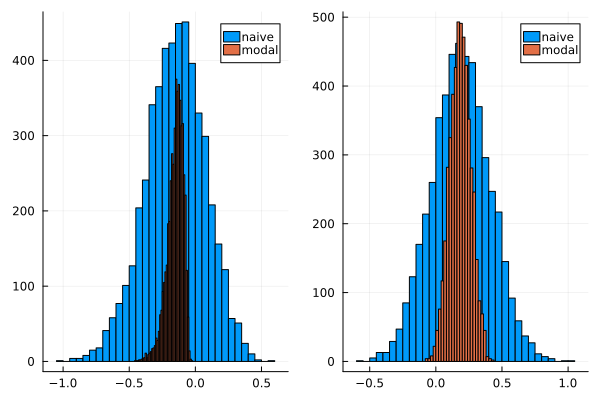

In [2]:
basis_order = 3
nb_iterations = 5000
ω = 0.5
input_mode = 1
basis_field_order = input_mode
F = mode_analysis(input_mode, ω, host_medium, sp_MC;
                radius_big_cylinder=radius_big_cylinder, 
                basis_order=basis_order, 
                basis_field_order=basis_field_order,
                nb_iterations=nb_iterations)[input_mode+1]

Fnaive = naive_sample_effective_t_matrix(ω, host_medium, sp_MC;
    radius_big_cylinder=radius_big_cylinder, 
    basis_order=basis_order, 
    basis_field_order=basis_field_order,
    nb_iterations=nb_iterations)[input_mode+1]

hr = histogram(real.(Fnaive),label="naive")
hr = histogram!(real.(F),label="modal")

hi = histogram(imag.(Fnaive),label="naive")
hi = histogram!(imag.(F),label="modal")

plot(hr,hi)

In [3]:
println(mean(F),"\n",
        mean(Fnaive)
)

-0.15312078126879541 + 0.18531690445849863im
-0.15146934508251475 + 0.18886427423878607im


# Let's check a part of the theory:
### -> The T-matrix of the average cylinder is diagonal!

In [4]:

basis_order = 3
basis_field_order = 5

nb_iterations = 5000
ω = 0.2
input_mode = 4
F = mode_analysis(input_mode, ω, host_medium, sp_MC;
                radius_big_cylinder=radius_big_cylinder, 
                basis_order=basis_order, 
                basis_field_order=basis_field_order,
                nb_iterations=nb_iterations);

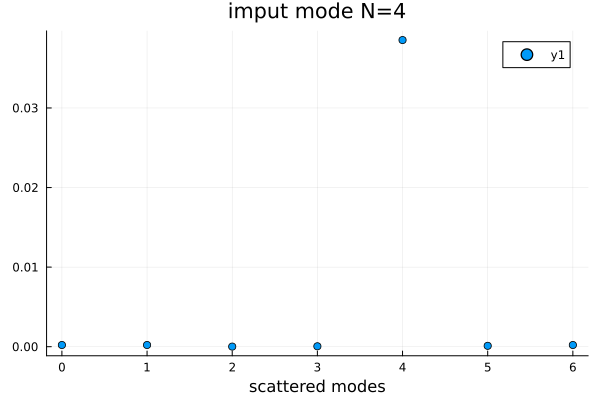

In [5]:
scatter(0:basis_field_order+1,abs.(mean.(F)))
scatter!(title="imput mode N="*string(input_mode),xlabel="scattered modes")

# Naive method VS Optimized method

In [6]:

basis_order = 3
nb_iterations = 5000
ω = 1.5
basis_field_order = 3
@time Fnaive = naive_sample_effective_t_matrix(ω, host_medium, sp_MC;
                radius_big_cylinder=radius_big_cylinder, 
                basis_order=basis_order, 
                basis_field_order=basis_field_order,
                nb_iterations=nb_iterations);

kws_MC = Dict(
    :radius_big_cylinder=>radius_big_cylinder
    ,:basis_order=> basis_order
    ,:basis_field_order=> basis_field_order
    ,:nb_iterations_max=> nb_iterations
    ,:nb_iterations_step=> nb_iterations
    ,:prec=>1e-2
)

@time Fmain = sample_effective_t_matrix(ω, host_medium, sp_MC;kws_MC...);

 89.149933 seconds (256.55 M allocations: 45.096 GiB, 5.93% gc time)
nb iterations:5000
modes still running:Bool[1, 1, 1, 1]

 30.324383 seconds (74.06 M allocations: 23.630 GiB, 5.97% gc time, 4.32% compilation time)


-0.3084210106972584 + 0.10500555914208644im
-0.3065981113340603 + 0.1100936198016172im


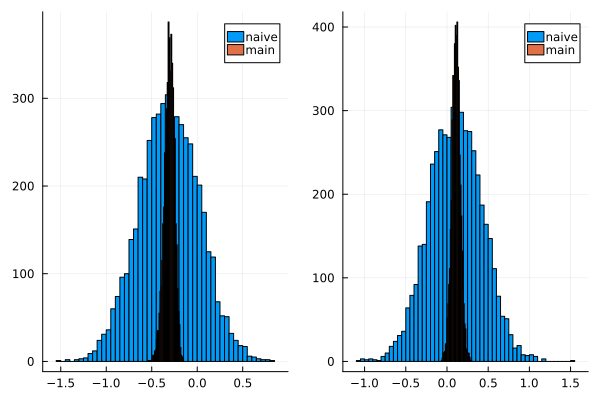

In [14]:
mode = 2
hr = histogram(real.(Fnaive[mode+1]),label="naive")
hr = histogram!(real.(Fmain[mode+1]),label="main")
hi = histogram(imag.(Fnaive[mode+1]),label="naive")
hi = histogram!(imag.(Fmain[mode+1]),label="main")

println(mean(Fnaive[mode+1]),"\n",
        mean(Fmain[mode+1])
)
plot(hr,hi)

# Stability

### Low frequency

In [8]:
ω = 0.1
basis_field_order = 5
Fstability_low_ω = [ComplexF64[] for _ in 0:basis_field_order]
for basis_order = 0:10
    kws_MC = Dict(
        :radius_big_cylinder=>radius_big_cylinder
        ,:basis_order=> basis_order
        ,:basis_field_order=> basis_field_order
        ,:nb_iterations_max=> 1000
        ,:nb_iterations_step=> 100
        ,:prec=>5e-2
    )

    push!.(Fstability_low_ω,mean.(sample_effective_t_matrix(ω, host_medium, sp_MC;kws_MC...)));
end

nb iterations:100
modes still running:Bool[1, 0, 1, 1, 1, 1]

nb iterations:200
modes still running:Bool[0, 0, 0, 1, 1, 1]

nb iterations:300
modes still running:Bool[0, 0, 0, 1, 1, 1]

nb iterations:400
modes still running:Bool[0, 0, 0, 0, 1, 0]

nb iterations:500
modes still running:Bool[0, 0, 0, 0, 0, 0]

nb iterations:100
modes still running:Bool[1, 1, 0, 1, 1, 1]

nb iterations:200
modes still running:Bool[1, 1, 0, 1, 1, 1]

nb iterations:300
modes still running:Bool[1, 1, 0, 0, 1, 1]

nb iterations:400
modes still running:Bool[1, 0, 0, 0, 0, 0]

nb iterations:500
modes still running:Bool[1, 0, 0, 0, 0, 0]

nb iterations:600
modes still running:Bool[1, 0, 0, 0, 0, 0]

nb iterations:700
modes still running:Bool[1, 0, 0, 0, 0, 0]

nb iterations:800
modes still running:Bool[1, 0, 0, 0, 0, 0]

nb iterations:900
modes still running:Bool[1, 0, 0, 0, 0, 0]

nb iterations:1000
modes still running:Bool[1, 0, 0, 0, 0, 0]

nb iterations:100
modes still running:Bool[1, 1, 0, 1, 1, 1]

nb iter

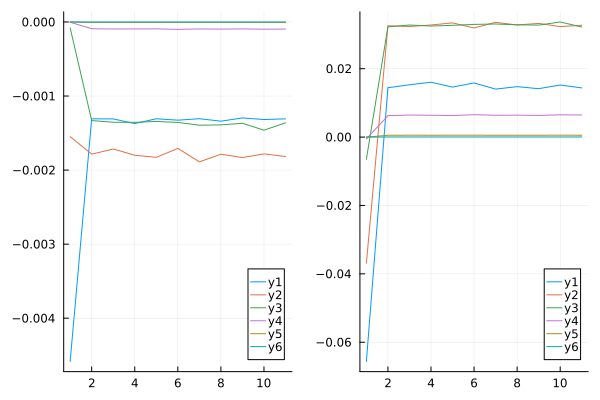

In [9]:
pr = plot(real.(Fstability_low_ω))
pim = plot(imag.(Fstability_low_ω))
plot(pr,pim)

### High frequency

In [10]:
ω = 1.0
basis_field_order = 5
Fstability_high_ω = [ComplexF64[] for _ in 0:basis_field_order]
for basis_order = 0:10
    kws_MC = Dict(
        :radius_big_cylinder=>radius_big_cylinder
        ,:basis_order=> basis_order
        ,:basis_field_order=> basis_field_order
        ,:nb_iterations_max=> 5000
        ,:nb_iterations_step=> 100
        ,:prec=>1e-2
    )

    push!.(Fstability_high_ω,mean.(sample_effective_t_matrix(ω, host_medium, sp_MC;kws_MC...)));
end

nb iterations:100
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:200
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:300
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:400
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:500
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:600
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:700
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:800
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:900
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:1000
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:1100
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:1200
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:1300
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:1400
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:1500
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:1600
modes still running:Bool[1, 1, 1, 1, 1, 1]

n

nb iterations:3200
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3300
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3400
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3500
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3600
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3700
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3800
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3900
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:4000
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:4100
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:4200
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:4300
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:4400
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:4500
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:4600
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:4700
modes still running:Bool[1, 1, 1, 1,

nb iterations:1300
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:1400
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:1500
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:1600
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:1700
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:1800
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:1900
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:2000
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:2100
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:2200
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:2300
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:2400
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:2500
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:2600
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:2700
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:2800
modes still running:Bool[1, 1, 1, 1,

nb iterations:4400
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:4500
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:4600
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:4700
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:4800
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:4900
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:5000
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:100
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:200
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:300
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:400
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:500
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:600
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:700
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:800
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:900
modes still running:Bool[1, 1, 1, 1, 1, 1]

n

nb iterations:2500
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:2600
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:2700
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:2800
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:2900
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3000
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3100
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3200
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3300
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3400
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3500
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3600
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3700
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3800
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:3900
modes still running:Bool[1, 1, 1, 1, 1, 1]

nb iterations:4000
modes still running:Bool[1, 1, 1, 1,

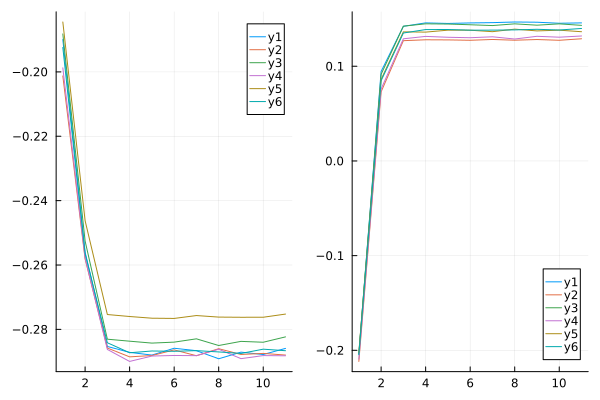

In [11]:
pr = plot(real.(Fstability_high_ω));
pim = plot(imag.(Fstability_high_ω));
plot(pr,pim)